In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path
import torch
from torchvision import transforms
import xmltodict
import json
import pickle as pkl
import copy
import random
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import tqdm

import numpy as np

from convert_f30ke import Flickr30KEntitiesDataset as FDS, objs_to_masks, DualMaskSampler

/USERSPACE/lukovdg1/venvs/sd3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def display_dual_masks(dualmasks):
    overlay = []
    for k, v in dualmasks.items():
        overlay.append(v.float() * torch.rand(3,1,1))
    overlay = torch.stack(overlay)
    counts = (overlay > 0).sum(0)
    print(overlay.shape)
    overlay = overlay.sum(0)
    print(overlay.shape)
    display(transforms.ToPILImage()(overlay))
    
    for k, v in dualmasks.items():
        print(k)
        display(transforms.ToPILImage()(v.float()))

In [4]:
l = list(range(10))
head, *tail = l
print(head, tail)

0 [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [19]:
fds = FDS()
dms = DualMaskSampler(return_type="dict", outerradius=50, innerradius=40)

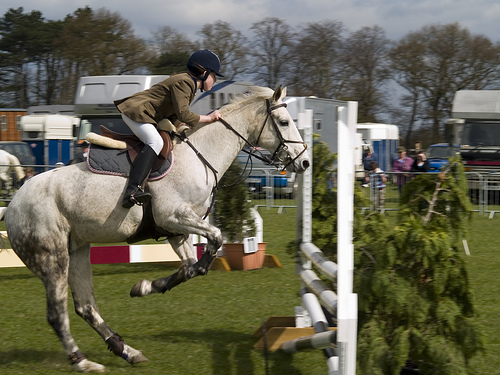

Pure text: Performer riding her horse over a jump . 
	 Spans: [(0, 9, 'Performer', 'EN#172325', 'people'), (17, 26, 'her horse', 'EN#172326', 'animals')]
torch.Size([2, 3, 375, 500])
torch.Size([3, 375, 500])


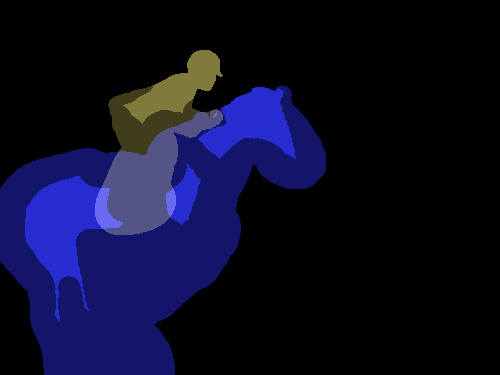

EN#172325


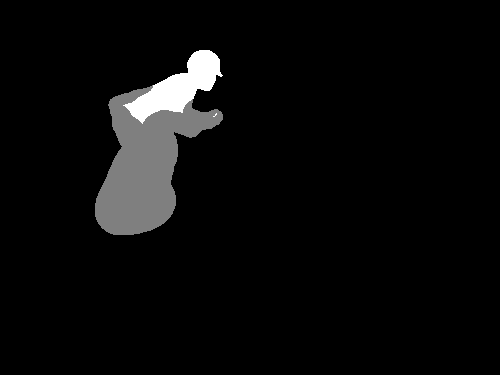

EN#172326


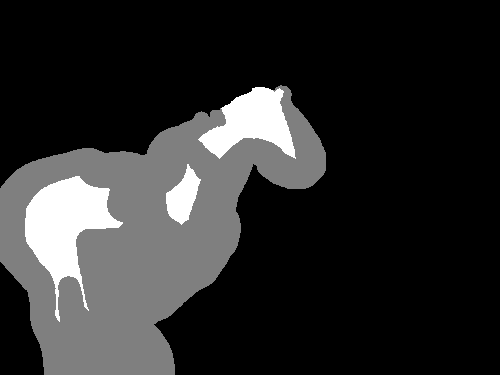

In [23]:
example = fds[7].m
ret = dms.sample(example)
caption, image, dmasks = ret
display(image)
print(caption)
display_dual_masks(dmasks)

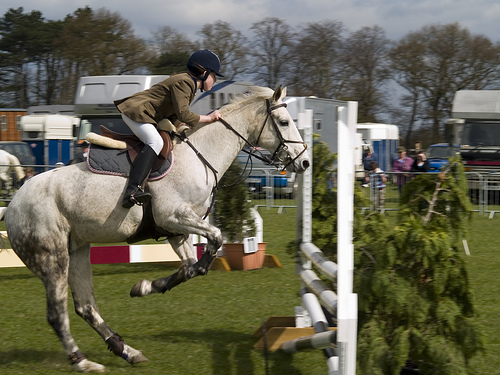

Pure text: Horse jumping 3 tiers of poles at a horse exhibition . 
	 Spans: [(0, 5, 'Horse', 'EN#172326', 'animals'), (14, 30, '3 tiers of poles', 'EN#172330', 'other')]
torch.Size([2, 3, 375, 500])
torch.Size([3, 375, 500])


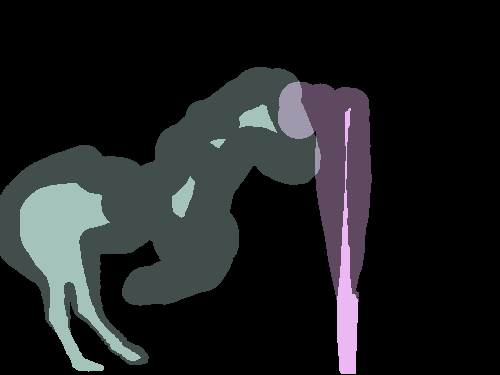

EN#172326


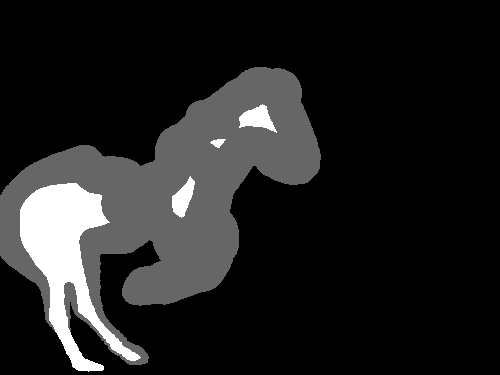

EN#172330


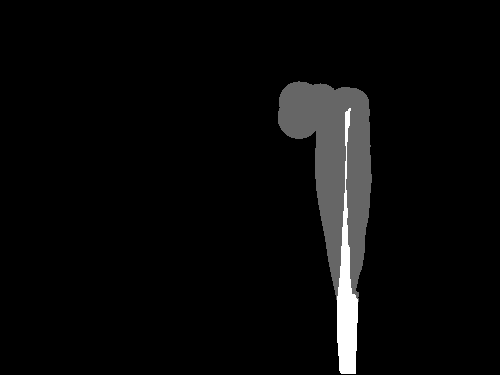

In [25]:
example = fds[7].m
caption, image, dmasks = example.sample_dualmasks()
display(image)
print(caption)
display_dual_masks(dmasks)

Pure text: Horse jumping 3 tiers of poles at a horse exhibition . 
	 Spans: [(0, 5, 'Horse', 'EN#172326', 'animals'), (14, 30, '3 tiers of poles', 'EN#172330', 'other')]
EN#172326 tensor(0.7500)


/tmp/ipykernel_636763/2495336085.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  display(transforms.ToPILImage()(torch.tensor(bboxmask).float()))


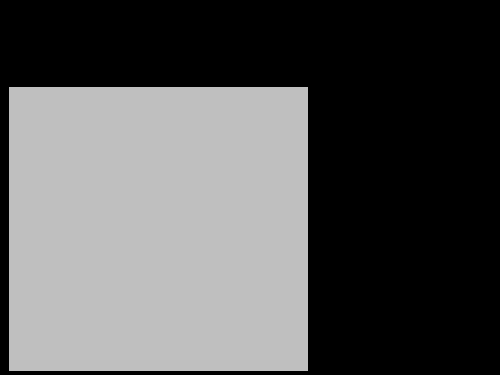

EN#172330 tensor(0.7500)


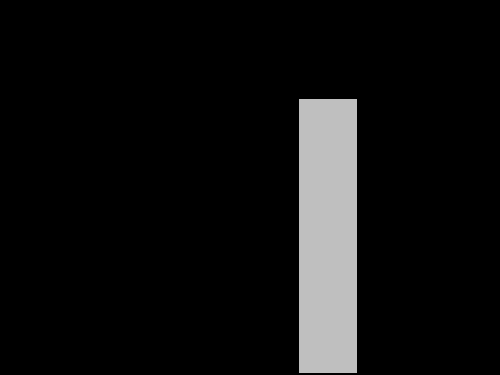

In [84]:
def generate_dualmask_bbox(m, outerboxlevel=0.75):
    m = torch.tensor(m)
    ret = torch.zeros_like(m).float()
    nonz = m.nonzero()
    mins, maxs = nonz.min(0)[0], nonz.max(0)[0]
    xmin, ymin = mins[0], mins[1]
    xmax, ymax = maxs[0], maxs[1]
    ret.data[xmin:xmax, ymin:ymax] = outerboxlevel
    return ret


caption, image, objs = example.sample()
print(caption)
masks = objs_to_masks(objs, image.size)
for k, v in masks.items():
    bboxmask = generate_dualmask_bbox(v)
    print(k, bboxmask.max())
    display(transforms.ToPILImage()(torch.tensor(bboxmask).float()))

Pure text: A person with a blue helmet on with black boots , who is riding a horse . 
	 Spans: [(0, 8, 'A person', 'EN#172325', 'people'), (14, 27, 'a blue helmet', 'EN#172328', 'clothing'), (36, 47, 'black boots', 'EN#172331', 'clothing'), (64, 71, 'a horse', 'EN#172326', 'animals')]


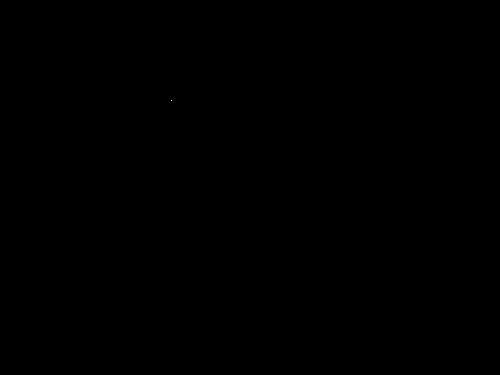

torch.Size([1, 2])
EN#172325


/tmp/ipykernel_636763/1076926124.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  display(transforms.ToPILImage()(torch.tensor(bboxmask).float()))


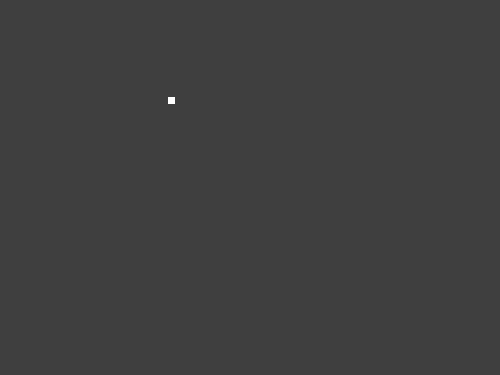

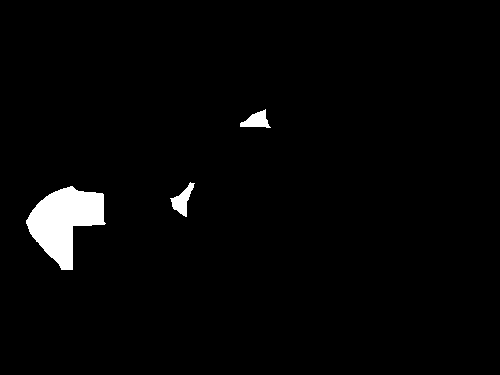

torch.Size([4403, 2])
EN#172326


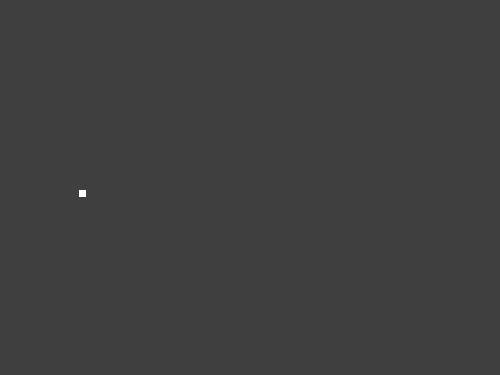

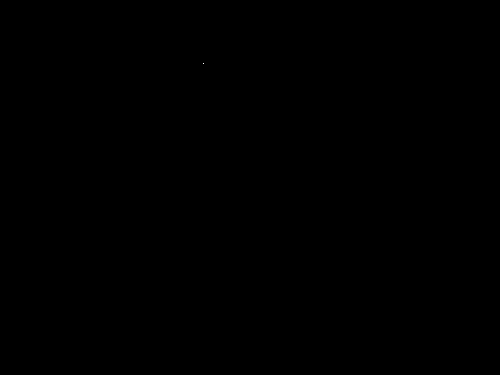

torch.Size([1, 2])
EN#172328


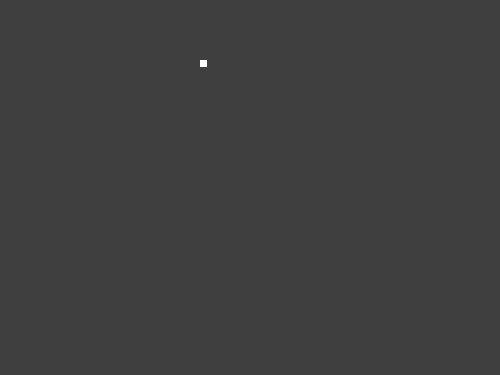

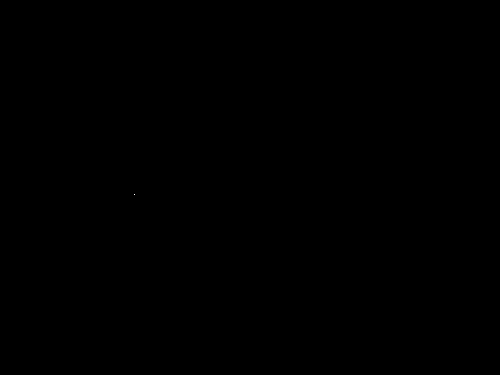

torch.Size([1, 2])
EN#172331


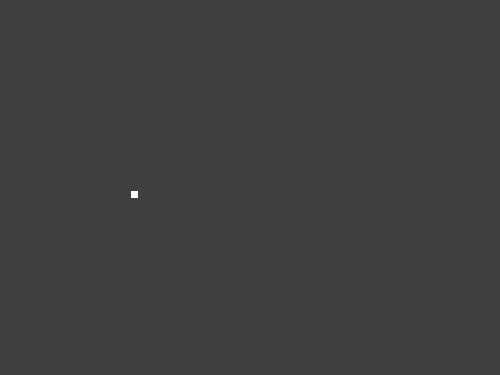

In [92]:
def generate_dualmask_point(m, outerboxlevel=0.25, innerboxlevel=1.):
    m = torch.tensor(m)
    ret = torch.ones_like(m).float() * outerboxlevel
    mblur = transforms.GaussianBlur(35, sigma=5.)(m.float()[None])[0]
    m_ = mblur == mblur.max()
    # display(transforms.ToPILImage()(m_.float()))
    nonz = m_.nonzero()
    idx = random.randint(0, nonz.shape[0]-1)
    point = nonz[idx]
    mins, maxs = nonz.min(0)[0], nonz.max(0)[0]
    xmin, ymin = point[0]-3, point[1]-3
    xmax, ymax = point[0]+4, point[1]+4
    ret.data[xmin:xmax, ymin:ymax] = innerboxlevel
    return ret


caption, image, objs = example.sample()
print(caption)
masks = objs_to_masks(objs, image.size)
for k, v in masks.items():
    bboxmask = generate_dualmask_point(v)
    print(k)
    display(transforms.ToPILImage()(torch.tensor(bboxmask).float()))

torch.Size([375, 500]) torch.Size([375, 500]) 30
torch.Size([375, 500]) torch.Size([375, 500]) 30
torch.Size([375, 500]) torch.Size([375, 500]) 30


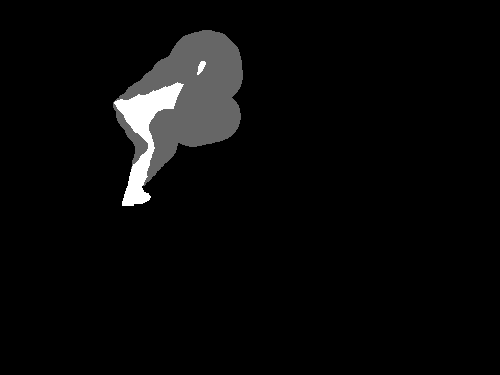

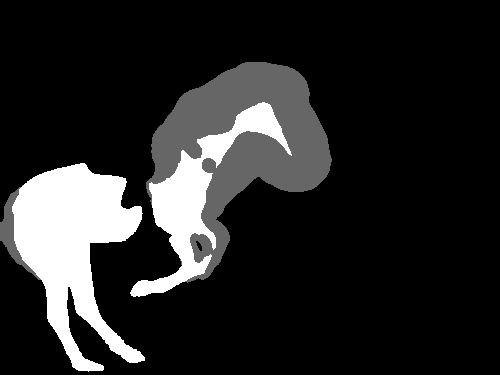

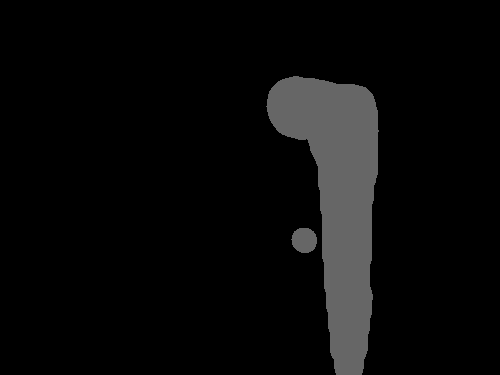

In [82]:
dualmasks = sample_dual_masks(caption, image, objs)
display_dual_masks(dualmasks)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
0
1
2
3
4
5
6
7
8
9
10
11
12


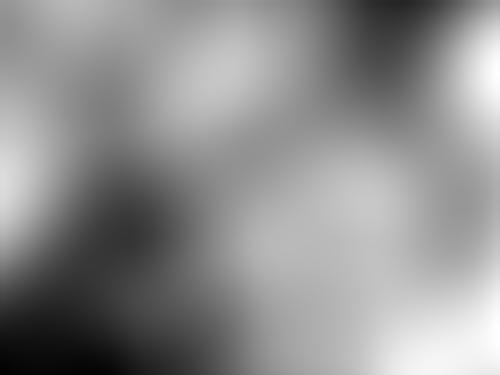

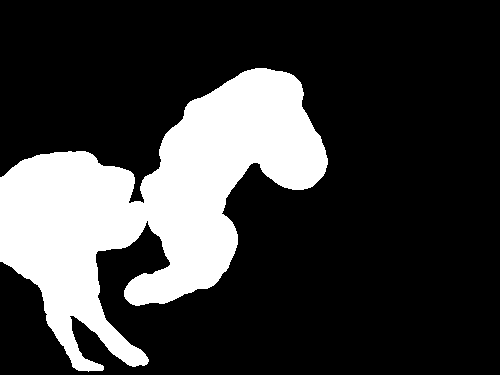

torch.Size([1, 375, 500])


In [232]:
rpmap = generate_random_precision_map(image.size[::-1])
ret = variable_hardblur_mask(torch.tensor(m).float(), rpmap*30, smoothing=17)

display(transforms.ToPILImage()(rpmap))
display(transforms.ToPILImage()(ret))
print(ret.shape)

In [ ]:

print(image.size)
maskdict = objs_to_masks(objs, image.size)
dualmasks = sample_dual_masks(

for k, m in maskdict.items():
    print(k)
    display(transforms.ToPILImage()(torch.tensor(m).float()))

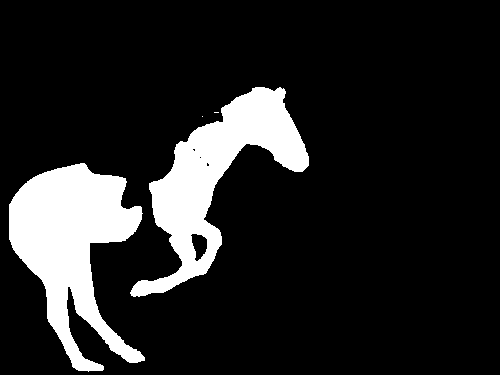

torch.Size([375, 500])


In [3]:
def get_sam(device=0):
    sam_checkpoint = "f30ke/sam_vit_h.pth"
    model_type = "vit_h"
    
    device = torch.device("cuda", device)
    
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    
    predictor = SamPredictor(sam)
    return predictor

In [4]:
random.randint(0, 60)

54

In [5]:
def draw_masks(image, masks):   # mask should be numpy
    overlay = Image.new('RGBA', image.size, (255,255,255,0))
    drawing = ImageDraw.Draw(overlay)
    for mask in masks:
        mask = mask.astype(np.uint8) * 255
        mask = Image.fromarray(mask, mode='L')
        drawing.bitmap((0, 0), mask, fill=tuple([random.randint(0, 255) for _ in range(3)] + [160]))
    image = Image.alpha_composite(image.convert("RGBA"), overlay)
    return image

In [6]:
sam = get_sam()

In [7]:
image = Image.open("f30ke/images/1000092795.jpg").convert("RGB")
sam.set_image(np.array(image))

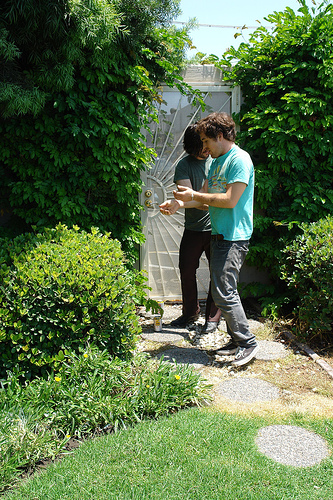

In [8]:
display(image)

In [9]:
input_box = np.array([0, 200, 150, 400])

masks, _, _ = sam.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

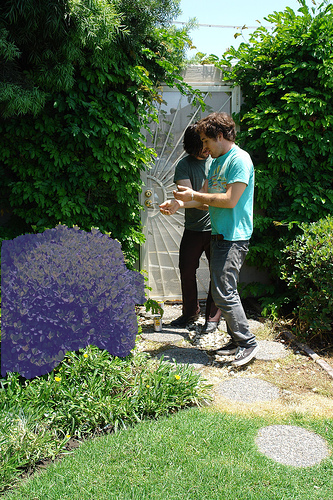

In [10]:
display(draw_masks(image, masks))

In [12]:
datadir = "/USERSPACE/lukovdg1/controlnet11/f30ke/"
imagedir = Path(datadir) / "images"
sentencedir = Path(datadir) / "sentences"
annotationdir = Path(datadir) / "annotations"

In [13]:
trainids = set([int(x.strip()) for x in open(Path(datadir) / "train.txt").readlines()])
testids = set([int(x.strip()) for x in open(Path(datadir) / "test.txt").readlines()])
valids = set([int(x.strip()) for x in open(Path(datadir) / "val.txt").readlines()])
    

In [14]:
len(testids)

1000

In [161]:
def get_objects(annotations):    # returns a dict of object specs
    # print(annotations.keys())
    objs = {}
    for objspec in annotations["annotation"]["object"]:
        name = objspec["name"]
        if "bndbox" not in objspec:
            continue
            
        if not set(objspec.keys()) == {"name", "bndbox"}:
            print(objspec)
        assert set(objspec.keys()) == {"name", "bndbox"}
        
        objspec = objspec["bndbox"]
        if not isinstance(name, list):
            name = [name]
        for namee in name:
            if f"EN#{namee}" not in objs:
                objs[f"EN#{namee}"] = []
            objs[f"EN#{namee}"].append(objspec)
    return objs


def add_bbox_to_spans(spans, objspecs):
    ret = []
    for span in spans:
        start, end, text, spanid, spantype = span
        if spanid == "EN#0":
            continue
        if spanid not in objspecs:
            continue
        objspec = objspecs[spanid]
        # retspan = (start, end, text, spanid, spantype, objspec)
        retspan = (start, end, text, spanid, spantype)
        ret.append(retspan)
    return ret


class Flickr30KCaption:
    def __init__(self, caption=None, annotations=None, objspecs=None, _loaded=False):
        # parse caption
        if not _loaded:
            self.original_caption = caption
            self.puretext, self.spans = self.parse_caption(caption)
            if annotations is not None:
                assert objspecs is None
                objspecs = get_objects(annotations)
            if objspecs is not None:
                self.spans = add_bbox_to_spans(self.spans, objspecs)

    def todict(self):
        keys = ["original_caption", "puretext", "spans"]
        ret = {}
        for k in keys:
            ret[k] = getattr(self, k)
        return ret

    @classmethod
    def fromdict(cls, d):
        ret = cls(_loaded=True)
        for k in d:
            setattr(ret, k, d[k])
        return ret

    @staticmethod
    def parse_caption(caption):
        # get spans, saving their ids and types
        caption = caption.strip()
        pieces = re.split(r"(\[[^\]]+\])", caption)
        spans = []
        puretext = ""
        for piece in pieces:
            m = re.match(r"\[/(EN#\d+)/(\w+)\s([^\]]+)\]", piece)
            if m:
                spanid = m.group(1)
                spantype = m.group(2)
                text = m.group(3)
                spans.append((len(puretext), len(puretext)+len(text), text, spanid, spantype))
            else:
                text = piece
            puretext += str(text)
        return puretext, spans

    def __repr__(self):
        return f"Pure text: {self.puretext} \n\t Spans: {self.spans}"

    def sample(self):
        ret = copy.deepcopy(self)
        # ret.spans = [span[:-1] + ([random.choice(span[-1])],) for span in ret.spans]
        return ret


In [180]:
class Flickr30KEntitiesExample:
    def __init__(self, imagepath=None, captionpath=None, annotationpath=None, image=None, captions=None, objs=None):
        self.imagepath = imagepath
        self.captionpath = captionpath
        self.annotationpath = annotationpath
        self.image = image
        self.captions = captions
        self.objs = objs

    def todict(self, incl_image=False):
        ret = {}
        keys = ["imagepath", "captionpath", "annotationpath", "captions", "objs", "image"]
        paths = ["imagepath", "captionpath", "annotationpath"]
        for k in keys:
            ret[k] = getattr(self, k)
        for k in paths:
            ret[k] = str(ret[k])
                
        if not incl_image:
            ret["image"] = None 
        dictcaptions = []
        for caption in ret["captions"]:
            dictcaptions.append(caption.todict())
        ret["captions"] = dictcaptions
        return ret
        
    @classmethod
    def fromdict(cls, d):
        ret = cls()
        for k in d:
            setattr(ret, k, d[k])
        dictcaptions = []
        for caption in ret.captions:
            dictcaptions.append(Flickr30KCaption.fromdict(caption))
        ret.captions = dictcaptions
        return ret

    @property
    def m(self):
        return self.materialize()

    def loadimage(self):
        self.image = Image.open(self.imagepath).convert("RGB")
        return self.image

    def materialize(self):
        # load image:
        self.loadimage()
        captions = open(self.captionpath).readlines()
        annotations = xmltodict.parse(open(self.annotationpath, "rb"))
        objs = get_objects(annotations)

        retcaptions = []
        for caption in captions:
            retcaptions.append(Flickr30KCaption(caption, objspecs=objs))
            
        return type(self)(imagepath=self.imagepath, captionpath=self.captionpath, annotationpath=self.annotationpath,
                          image=image, captions=retcaptions, objs=objs)

    def compute_masks_for_boxes(self, sam):
        assert self.image is not None and self.objs is not None    # must be materialized example
        bboxarray = []
        bboxes = []
        for objkey, obj in self.objs.items():
            for bbox in obj:
                bboxes.append(bbox)
                bboxarray.append([int(a) for a in [bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]]])
                
        bboxarray = torch.tensor(bboxarray, device=sam.device)

        sam.set_image(np.array(self.image.convert("RGB")))
        
        transformed_boxes = sam.transform.apply_boxes_torch(bboxarray, self.image.size)
        
        masks, _, _ = sam.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        masks = masks.cpu().numpy()
        for mask, obj in zip(list(masks), bboxes):
            obj["mask"] = mask[0, int(obj["ymin"]):int(obj["ymax"]), int(obj["xmin"]):int(obj["xmax"]), ]
            

    def __repr__(self):
        return f"Flickr30KEntitiesExample: \n\timage path: {self.imagepath}, \n\tcaption path: {self.captionpath}, \n\tannotations path: {self.annotationpath}"

    def test_paths(self):
        assert self.imagepath.exists()
        assert self.captionpath.exists()
        assert self.annotationpath.exists()

    def display_notebook(self):
        image, retcaptions = self.materialize()
        display(image)
        print(json.dumps([str(retcaption) for retcaption in retcaptions], indent=4))

    def sample(self):
        caption = random.choice(self.captions)
        caption = caption.sample()

        # draw = ImageDraw.Draw(self.image.convert("RGBA"))
        image = self.image
        maskoverlay = Image.new('RGBA', image.size, (255,255,255,0))
        bboxoverlay = Image.new('RGBA', image.size, (255,255,255,0))
        maskdrawing = ImageDraw.Draw(maskoverlay)
        bboxdrawing = ImageDraw.Draw(bboxoverlay)
        for span in caption.spans:
            for bbox in self.objs[span[3]]:
                bboxdrawing.rectangle(((int(bbox["xmin"]), int(bbox["ymin"])), (int(bbox["xmax"]), int(bbox["ymax"]))), outline="red")
                if "mask" in bbox:
                    mask = bbox["mask"].astype(np.uint8) * 255
                    mask = Image.fromarray(mask, mode='L')
                    maskdrawing.bitmap((int(bbox["xmin"]), int(bbox["ymin"])), mask, fill=tuple([random.randint(100, 255) for _ in range(3)] + [160]))
                    # drawing.bitmap((0, 0), mask, fill=tuple([random.randint(100, 255) for _ in range(3)] + [160]))
        image = Image.alpha_composite(image.convert("RGBA"), maskoverlay)
        image = Image.alpha_composite(image.convert("RGBA"), bboxoverlay)
        return caption, image
        


class Flickr30KEntitiesDataset:
    def __init__(self, datadir="/USERSPACE/lukovdg1/controlnet11/f30ke/", split="train", **kw):
        super().__init__(**kw)
        datadir = Path(datadir)
        self.datadir = datadir
        self.imagedir = datadir / "images"
        self.captiondir = datadir / "sentences"
        self.annotationdir = datadir / "annotations"
        self.split = split
        self.imgids = set([int(x.strip()) for x in open(datadir / f"{split}.txt").readlines()])
        self.examples = {}
        self.exampleids = []
        self.load_data()

    def load_data(self):
        for imgid in self.imgids:
            example = Flickr30KEntitiesExample(self.imagedir / f"{imgid}.jpg",
                                               self.captiondir / f"{imgid}.txt",
                                               self.annotationdir / f"{imgid}.xml")
            example.test_paths()
            self.examples[imgid] = example
            self.exampleids.append(imgid)

    def __getitem__(self, i):
        ret = self.examples[self.exampleids[i]]
        return ret

    def __len__(self):
        return len(self.exampleids)
        
        

In [181]:
ds = Flickr30KEntitiesDataset(split="val")

In [182]:
len(ds.examples)
x = ds[6]

(500, 375)
Pure text: Two young girls selling trinkets . 
	 Spans: [(0, 15, 'Two young girls', 'EN#185125', 'people'), (24, 32, 'trinkets', 'EN#185128', 'other')]


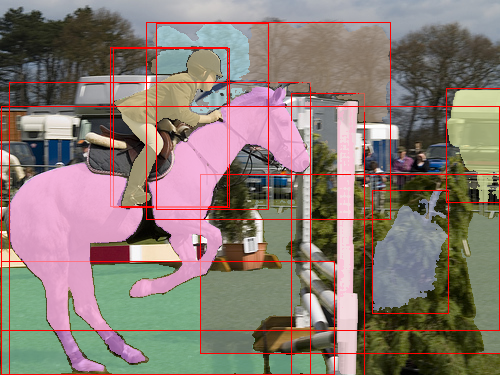

In [183]:
xx = x.materialize()
print(xx.image.size)
xx.compute_masks_for_boxes(sam)

caption, image = xx.sample()
print(caption)
display(image)

In [184]:
pkl.dump(xx.todict(), open("testsave.f30ke.pkl", "wb"))

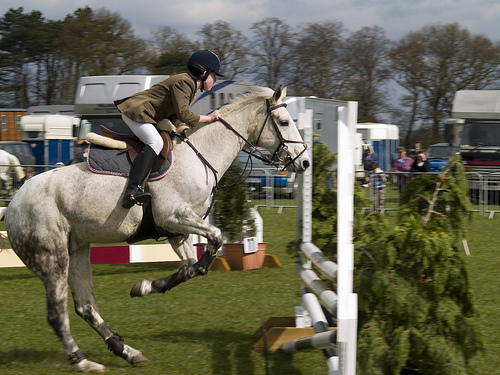

In [138]:
reloaded = pkl.load(open("testsave.f30ke.pkl", "rb"))
reloaded = Flickr30KEntitiesExample.fromdict(reloaded)
reloaded.loadimage()

Pure text: A show horse being ridden by a woman in jockey clothes is about to jump over a white steeple on a green field in front of a parking lot with camper vans in it . 
	 Spans: [(0, 12, 'A show horse', 'EN#172326', 'animals'), (29, 36, 'a woman', 'EN#172325', 'people'), (40, 54, 'jockey clothes', 'EN#172333', 'clothing'), (77, 92, 'a white steeple', 'EN#172330', 'other'), (96, 109, 'a green field', 'EN#172335', 'scene'), (141, 152, 'camper vans', 'EN#172332', 'other')]


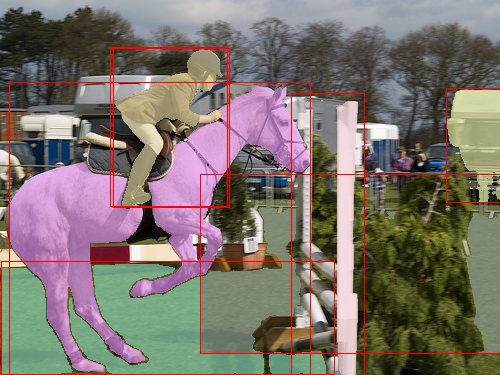

/USERSPACE/lukovdg1/controlnet11/f30ke/images/448493587.jpg


In [146]:
caption, image = reloaded.sample()
print(caption)
display(image)
print(reloaded.imagepath)

In [ ]:
ds = Flickr30KEntitiesDataset(split="val")
outdir = Path("/USERSPACE/lukovdg1/controlnet11/f30ke/dictpickles/")
for imgid in tqdm.tqdm(ds.exampleids):
    filename = outdir / f"{imgid}.dict.pkl"
    x = ds.examples[imgid]
    x = x.materialize()
    x.compute_masks_for_boxes(sam)
    xdict = x.todict()
    pkl.dump(xdict, open(filename, "wb"))

  8%|████████▏                                                                                                  | 77/1000 [00:39<07:47,  1.98it/s]

In [408]:
masks.shape

(10, 1, 500, 333)